In [2]:
import os
import hashlib
import requests
import zipfile, tarfile
import numpy as np
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

def download():
    url, sha1_hash = ('http://d2l-data.s3-accelerate.amazonaws.com/ctr.zip',
                        'e18327c48c8e8e5c23da714dd614e390d369843f')
    cache_dir=os.path.join('..', 'data')
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(folder=None):
    fname = download()
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


In [21]:
class CTRDataset(Dataset):
    def __init__(self, data_path, feat_mapper=None, defaults=None,
                 min_threshold=4, num_feat=34):
        self.NUM_FEATS, self.count, self.data = num_feat, 0, {}
        feat_cnts = defaultdict(lambda: defaultdict(int))
        self.feat_mapper, self.defaults = feat_mapper, defaults
        self.field_dims = np.zeros(self.NUM_FEATS, dtype=np.int64)
        with open(data_path) as f:
            for line in f:
                instance = {}
                values = line.rstrip('\n').split('\t')
                if len(values) != self.NUM_FEATS + 1:
                    continue
                label = np.float32([0, 0])
                label[int(values[0])] = 1
                instance['y'] = [np.float32(values[0])]
                for i in range(1, self.NUM_FEATS + 1):
                    feat_cnts[i][values[i]] += 1
                    instance.setdefault('x', []).append(values[i])
                self.data[self.count] = instance
                self.count = self.count + 1
        if self.feat_mapper is None and self.defaults is None:
            feat_mapper = {i: {feat for feat, c in cnt.items() if c >=
                               min_threshold} for i, cnt in feat_cnts.items()}
            self.feat_mapper = {i: {feat_v: idx for idx, feat_v in enumerate(feat_values)}
                                for i, feat_values in feat_mapper.items()}
            self.defaults = {i: len(feat_values) for i, feat_values in feat_mapper.items()}
        for i, fm in self.feat_mapper.items():
            self.field_dims[i - 1] = len(fm) + 1
        self.offsets = np.array((0, *np.asarray(np.cumsum(self.field_dims))
                                 [:-1]))

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        feat = np.array([self.feat_mapper[i + 1].get(v, self.defaults[i + 1])
                         for i, v in enumerate(self.data[idx]['x'])])
        return feat + self.offsets, self.data[idx]['y']

In [28]:
class DeepFM(nn.Module):
    def __init__(self, field_dims, num_factors, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Linear(1, 1)
        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp = []
        for dim in mlp_dims:
            self.mlp.append(nn.Linear(input_dim, dim))
            self.mlp.append(nn.ReLU())
            self.mlp.append(nn.Dropout(p=drop_rate))
            input_dim = dim
        self.mlp.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*self.mlp)

    def forward(self, x):
        embed_x = self.embedding(x)
        square_of_sum = torch.sum(embed_x, axis=1) ** 2
        sum_of_square = torch.sum(embed_x ** 2, axis=1)
        inputs = embed_x.view(-1, self.embed_output_dim)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True) \
            + self.mlp(inputs)
        x = torch.sigmoid(x)
        return x

In [29]:
batch_size = 2048
data_dir = download_extract()
train_data = CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = DataLoader(train_data, shuffle=True, batch_size = batch_size)
test_iter = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = DeepFM(train_data.field_dims, num_factors=20, mlp_dims=[30, 20, 10])
net.to(device)
lr, num_epochs, wd = 0.002, 50, 1e-5
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=wd)

In [31]:
from tqdm import tqdm
import glob

train_epoch_loss = []
val_epoch_loss_lst = []
best_val_epoch_loss = int(1e9)
for epoch in tqdm(range(num_epochs)):
  train_iter_loss = []
  for i, values in enumerate(train_iter):
    train_data = values[0].long().to(device)
    labels = values[1][0].long().to(device).unsqueeze(1) 
    preds = net(train_data) #.squeeze()
    loss = loss_func(preds.to(torch.float32), labels.to(torch.float32))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_iter_loss.append(loss.detach().item())
    if i%50 == 0:
      print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
  train_epoch_loss.append(np.mean(train_iter_loss))
  print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))
  
  with torch.no_grad():
    net.eval()
    val_epoch_loss = 0
    for i, values in enumerate(test_iter):
      test_data = values[0].long().to(device)
      labels = values[1][0].long().to(device).unsqueeze(1) 
      preds = net(test_data)
      loss = loss_func(preds.to(torch.float32), labels.to(torch.float32))
      val_epoch_loss += loss.detach().item()
  val_epoch_loss /= len(test_iter)
  val_epoch_loss_lst.append(val_epoch_loss)

  if val_epoch_loss < best_val_epoch_loss:
    best_val_epoch_loss = val_epoch_loss
    print(f'New best model loss: {best_val_epoch_loss}')
    if not os.path.exists('model'):
      os.mkdir('model')

    if os.path.exists('model/best.pth'):
      os.remove('model/best.pth')
    torch.save(net.state_dict(), 'model/best.pth')
    print('best model is saved!')
    
  

  0%|          | 0/50 [00:00<?, ?it/s]

0 epoch 0th train iter loss: 40.83259582519531


  2%|▏         | 1/50 [00:00<00:45,  1.08it/s]

0 epoch ALL LOSS :  40.031334400177
New best model loss: 37.40003204345703
best model is saved!
1 epoch 0th train iter loss: 38.229217529296875


  4%|▍         | 2/50 [00:01<00:35,  1.36it/s]

1 epoch ALL LOSS :  36.09484815597534
New best model loss: 33.06837463378906
best model is saved!
2 epoch 0th train iter loss: 32.89509582519531


  6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

2 epoch ALL LOSS :  32.45088267326355
New best model loss: 29.503297805786133
best model is saved!
3 epoch 0th train iter loss: 31.717641830444336


  8%|▊         | 4/50 [00:02<00:31,  1.48it/s]

3 epoch ALL LOSS :  30.99166440963745
4 epoch 0th train iter loss: 31.31369400024414


 10%|█         | 5/50 [00:03<00:28,  1.57it/s]

4 epoch ALL LOSS :  34.05781269073486
5 epoch 0th train iter loss: 35.988304138183594


 12%|█▏        | 6/50 [00:03<00:26,  1.67it/s]

5 epoch ALL LOSS :  37.72221565246582
6 epoch 0th train iter loss: 38.51770782470703


 14%|█▍        | 7/50 [00:04<00:24,  1.77it/s]

6 epoch ALL LOSS :  38.75284385681152
7 epoch 0th train iter loss: 36.82433319091797


 16%|█▌        | 8/50 [00:04<00:22,  1.85it/s]

7 epoch ALL LOSS :  36.74136734008789
8 epoch 0th train iter loss: 35.136802673339844


 18%|█▊        | 9/50 [00:05<00:22,  1.80it/s]

8 epoch ALL LOSS :  34.43434715270996
9 epoch 0th train iter loss: 35.7198486328125


 20%|██        | 10/50 [00:06<00:22,  1.81it/s]

9 epoch ALL LOSS :  32.82834029197693
10 epoch 0th train iter loss: 32.91357421875


 22%|██▏       | 11/50 [00:06<00:20,  1.87it/s]

10 epoch ALL LOSS :  31.846435546875
11 epoch 0th train iter loss: 30.269643783569336


 24%|██▍       | 12/50 [00:07<00:21,  1.81it/s]

11 epoch ALL LOSS :  30.03439211845398
12 epoch 0th train iter loss: 29.70044708251953


 26%|██▌       | 13/50 [00:07<00:20,  1.80it/s]

12 epoch ALL LOSS :  28.50477433204651
New best model loss: 28.232916831970215
best model is saved!
13 epoch 0th train iter loss: 26.937068939208984


 28%|██▊       | 14/50 [00:08<00:21,  1.67it/s]

13 epoch ALL LOSS :  26.69394016265869
New best model loss: 25.056361198425293
best model is saved!
14 epoch 0th train iter loss: 25.450416564941406


 30%|███       | 15/50 [00:08<00:20,  1.70it/s]

14 epoch ALL LOSS :  23.474169492721558
New best model loss: 23.320996284484863
best model is saved!
15 epoch 0th train iter loss: 22.106666564941406


 32%|███▏      | 16/50 [00:09<00:19,  1.73it/s]

15 epoch ALL LOSS :  22.384140491485596
New best model loss: 19.79927921295166
best model is saved!
16 epoch 0th train iter loss: 21.229816436767578


 34%|███▍      | 17/50 [00:10<00:18,  1.76it/s]

16 epoch ALL LOSS :  19.710220098495483
New best model loss: 19.351819038391113
best model is saved!
17 epoch 0th train iter loss: 18.807693481445312


 36%|███▌      | 18/50 [00:10<00:19,  1.67it/s]

17 epoch ALL LOSS :  18.256134748458862
New best model loss: 16.128771781921387
best model is saved!
18 epoch 0th train iter loss: 15.58908462524414


 38%|███▊      | 19/50 [00:11<00:17,  1.73it/s]

18 epoch ALL LOSS :  16.601072549819946
New best model loss: 15.14638090133667
best model is saved!
19 epoch 0th train iter loss: 13.480133056640625


 40%|████      | 20/50 [00:11<00:16,  1.78it/s]

19 epoch ALL LOSS :  14.567777633666992
New best model loss: 12.681089401245117
best model is saved!
20 epoch 0th train iter loss: 13.210480690002441


 42%|████▏     | 21/50 [00:12<00:16,  1.78it/s]

20 epoch ALL LOSS :  13.100658059120178
New best model loss: 11.594634056091309
best model is saved!
21 epoch 0th train iter loss: 12.215960502624512


 44%|████▍     | 22/50 [00:13<00:16,  1.66it/s]

21 epoch ALL LOSS :  11.555198550224304
New best model loss: 11.09849739074707
best model is saved!
22 epoch 0th train iter loss: 11.805994033813477


 46%|████▌     | 23/50 [00:13<00:15,  1.70it/s]

22 epoch ALL LOSS :  11.061305046081543
New best model loss: 10.237969875335693
best model is saved!
23 epoch 0th train iter loss: 10.423738479614258


 48%|████▊     | 24/50 [00:14<00:14,  1.74it/s]

23 epoch ALL LOSS :  10.026164531707764
New best model loss: 9.371363162994385
best model is saved!
24 epoch 0th train iter loss: 10.10979175567627


 50%|█████     | 25/50 [00:14<00:13,  1.87it/s]

24 epoch ALL LOSS :  9.226050615310669
New best model loss: 9.045873641967773
best model is saved!
25 epoch 0th train iter loss: 7.712798118591309


 52%|█████▏    | 26/50 [00:15<00:12,  1.94it/s]

25 epoch ALL LOSS :  8.42124879360199
New best model loss: 8.261923789978027
best model is saved!
26 epoch 0th train iter loss: 7.6324052810668945


 54%|█████▍    | 27/50 [00:15<00:12,  1.84it/s]

26 epoch ALL LOSS :  7.652760207653046
27 epoch 0th train iter loss: 7.205610752105713


 56%|█████▌    | 28/50 [00:16<00:11,  1.90it/s]

27 epoch ALL LOSS :  7.144689738750458
28 epoch 0th train iter loss: 6.655155658721924


 58%|█████▊    | 29/50 [00:16<00:10,  1.96it/s]

28 epoch ALL LOSS :  6.849704384803772
29 epoch 0th train iter loss: 7.3394775390625


 60%|██████    | 30/50 [00:17<00:09,  2.01it/s]

29 epoch ALL LOSS :  6.24709951877594
New best model loss: 7.813644647598267
best model is saved!
30 epoch 0th train iter loss: 6.009182453155518


 62%|██████▏   | 31/50 [00:17<00:10,  1.88it/s]

30 epoch ALL LOSS :  5.83645886182785
New best model loss: 7.55126953125
best model is saved!
31 epoch 0th train iter loss: 6.9739837646484375


 64%|██████▍   | 32/50 [00:18<00:09,  1.89it/s]

31 epoch ALL LOSS :  5.587188184261322
New best model loss: 6.834076881408691
best model is saved!
32 epoch 0th train iter loss: 5.503795623779297


 66%|██████▌   | 33/50 [00:18<00:08,  1.97it/s]

32 epoch ALL LOSS :  5.187675416469574
New best model loss: 6.111038684844971
best model is saved!
33 epoch 0th train iter loss: 4.670981407165527


 68%|██████▊   | 34/50 [00:19<00:07,  2.02it/s]

33 epoch ALL LOSS :  4.895910620689392
34 epoch 0th train iter loss: 4.564958095550537


 70%|███████   | 35/50 [00:19<00:07,  1.95it/s]

34 epoch ALL LOSS :  4.728210389614105
New best model loss: 5.595307111740112
best model is saved!
35 epoch 0th train iter loss: 4.243418216705322


 72%|███████▏  | 36/50 [00:20<00:07,  1.94it/s]

35 epoch ALL LOSS :  4.502475470304489
New best model loss: 5.371298313140869
best model is saved!
36 epoch 0th train iter loss: 4.4398040771484375


 74%|███████▍  | 37/50 [00:20<00:06,  1.95it/s]

36 epoch ALL LOSS :  4.398535847663879
37 epoch 0th train iter loss: 4.112563133239746


 76%|███████▌  | 38/50 [00:21<00:06,  1.97it/s]

37 epoch ALL LOSS :  4.220586329698563
38 epoch 0th train iter loss: 4.250271797180176


 78%|███████▊  | 39/50 [00:21<00:05,  1.96it/s]

38 epoch ALL LOSS :  3.9359026551246643
New best model loss: 4.684749603271484
best model is saved!
39 epoch 0th train iter loss: 3.990074396133423


 80%|████████  | 40/50 [00:22<00:05,  1.91it/s]

39 epoch ALL LOSS :  3.824028432369232
40 epoch 0th train iter loss: 3.681398868560791


 82%|████████▏ | 41/50 [00:22<00:04,  2.01it/s]

40 epoch ALL LOSS :  3.946272850036621
41 epoch 0th train iter loss: 4.489659309387207


 84%|████████▍ | 42/50 [00:23<00:03,  2.08it/s]

41 epoch ALL LOSS :  3.8355216681957245
42 epoch 0th train iter loss: 3.7009475231170654


 86%|████████▌ | 43/50 [00:23<00:03,  2.08it/s]

42 epoch ALL LOSS :  3.783873200416565
New best model loss: 4.453169345855713
best model is saved!
43 epoch 0th train iter loss: 3.554664373397827


 88%|████████▊ | 44/50 [00:24<00:03,  1.97it/s]

43 epoch ALL LOSS :  3.5202051997184753
44 epoch 0th train iter loss: 3.1310746669769287


 90%|█████████ | 45/50 [00:24<00:02,  1.98it/s]

44 epoch ALL LOSS :  3.5817212760448456
45 epoch 0th train iter loss: 3.3841068744659424


 92%|█████████▏| 46/50 [00:25<00:02,  1.99it/s]

45 epoch ALL LOSS :  3.507617324590683
New best model loss: 4.374750375747681
best model is saved!
46 epoch 0th train iter loss: 3.2274460792541504


 94%|█████████▍| 47/50 [00:25<00:01,  2.02it/s]

46 epoch ALL LOSS :  3.528108537197113
47 epoch 0th train iter loss: 3.469398021697998


 96%|█████████▌| 48/50 [00:26<00:01,  1.99it/s]

47 epoch ALL LOSS :  3.4954930245876312
New best model loss: 4.252176523208618
best model is saved!
48 epoch 0th train iter loss: 3.6684913635253906


 98%|█████████▊| 49/50 [00:26<00:00,  2.07it/s]

48 epoch ALL LOSS :  3.3767002522945404
49 epoch 0th train iter loss: 3.9946653842926025


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

49 epoch ALL LOSS :  3.437002122402191


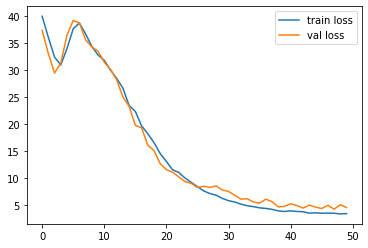

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_epoch_loss, label='train loss')
plt.plot(val_epoch_loss_lst, label='val loss')
plt.legend()